<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Titanic/blob/Model-tuning/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pipeline:
0. Concatenate Train & Test
1. Feature generation ('Cabin', 'Parch' analysis)
2. Splitting Train & Test back
3. Pipeline for preprocessing
4. Model selection
5. Submission


In [198]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import shapiro

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 

In [4]:
def nan_percentage(df, colname):
  return (df[colname].isnull().sum() / df.shape[0]) * 100

def standardize_col(df, cols):
  for col in cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

def remove_outliers(df, col):
  Q1 = np.quantile(df[col], 0.25)
  Q3 = np.quantile(df[col], 0.75)
  IQR = Q3 - Q1

  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR

  print(f'lower = {lower}, upper = {upper}, IQR = {IQR}')

  # after filtering, keep only data within [lower, upper]
  filtered_vals = [x for x in df[col] if (x > lower) & (x < upper)]
  return df.loc[df[col].isin(filtered_vals)]

def nan_statistics(df):
  nan_cols = df.loc[:, df.isnull().any()].columns
  for col in nan_cols:
    print(f'Column {col} has {nan_percentage(df, col):.2f} % of Nans')
  print(df.isna().sum())

def nans_remain(df):
  return df.isnull().values.any()

#**1. Concatenate train & test**

In [5]:
# Setting file download from google Drive

drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'
df_path = 'ML/Datasets/1.Titanic/'

train_path = gdrive_path + df_path + "train.csv"
test_path =  gdrive_path + df_path + "test.csv"

Mounted at /content/gdrive


In [86]:
train = pd.read_csv(train_path, index_col='PassengerId')
test = pd.read_csv(test_path, index_col='PassengerId')
df_whole = pd.concat([train, test], sort=True)

#**2. Feature Exploration ('Cabin', 'Parch')**

In [89]:
# Step 1. General Summary
df_whole.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       1046 non-null   float64
 1   Cabin     295 non-null    object 
 2   Embarked  1307 non-null   object 
 3   Fare      1308 non-null   float64
 4   Name      1309 non-null   object 
 5   Parch     1309 non-null   int64  
 6   Pclass    1309 non-null   int64  
 7   Sex       1309 non-null   object 
 8   SibSp     1309 non-null   int64  
 9   Survived  891 non-null    float64
 10  Ticket    1309 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [93]:
# Age -> substitute with average / median
# Embarked -> substitute column (depends on significancy)
# Name, Ticket -> can drop the column

# 'Embarked' feature has two Nans -> Mrs.George Nelson & Amelie Icard
# embarked in Southampton -> substitute with S

df_whole['Embarked'] = df_whole['Embarked'].fillna('S')
Cabins = df_whole.loc[:, 'Cabin']
Cabins.fillna('M', inplace=True)

# Leave only names of the Cabin sections
Cabins = Cabins.str.slice(0, 1)
Cabins.value_counts()
df_whole['Cabin'] = Cabins.values

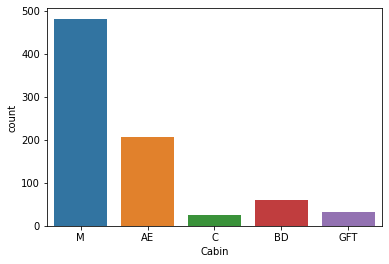

In [123]:
survived = df_whole[df_whole['Survived'] == 1]
died = df_whole[df_whole['Survived'] == 0]
sns.countplot(x = 'Cabin', data=survived)
sns.countplot(x='Cabin', data=died)

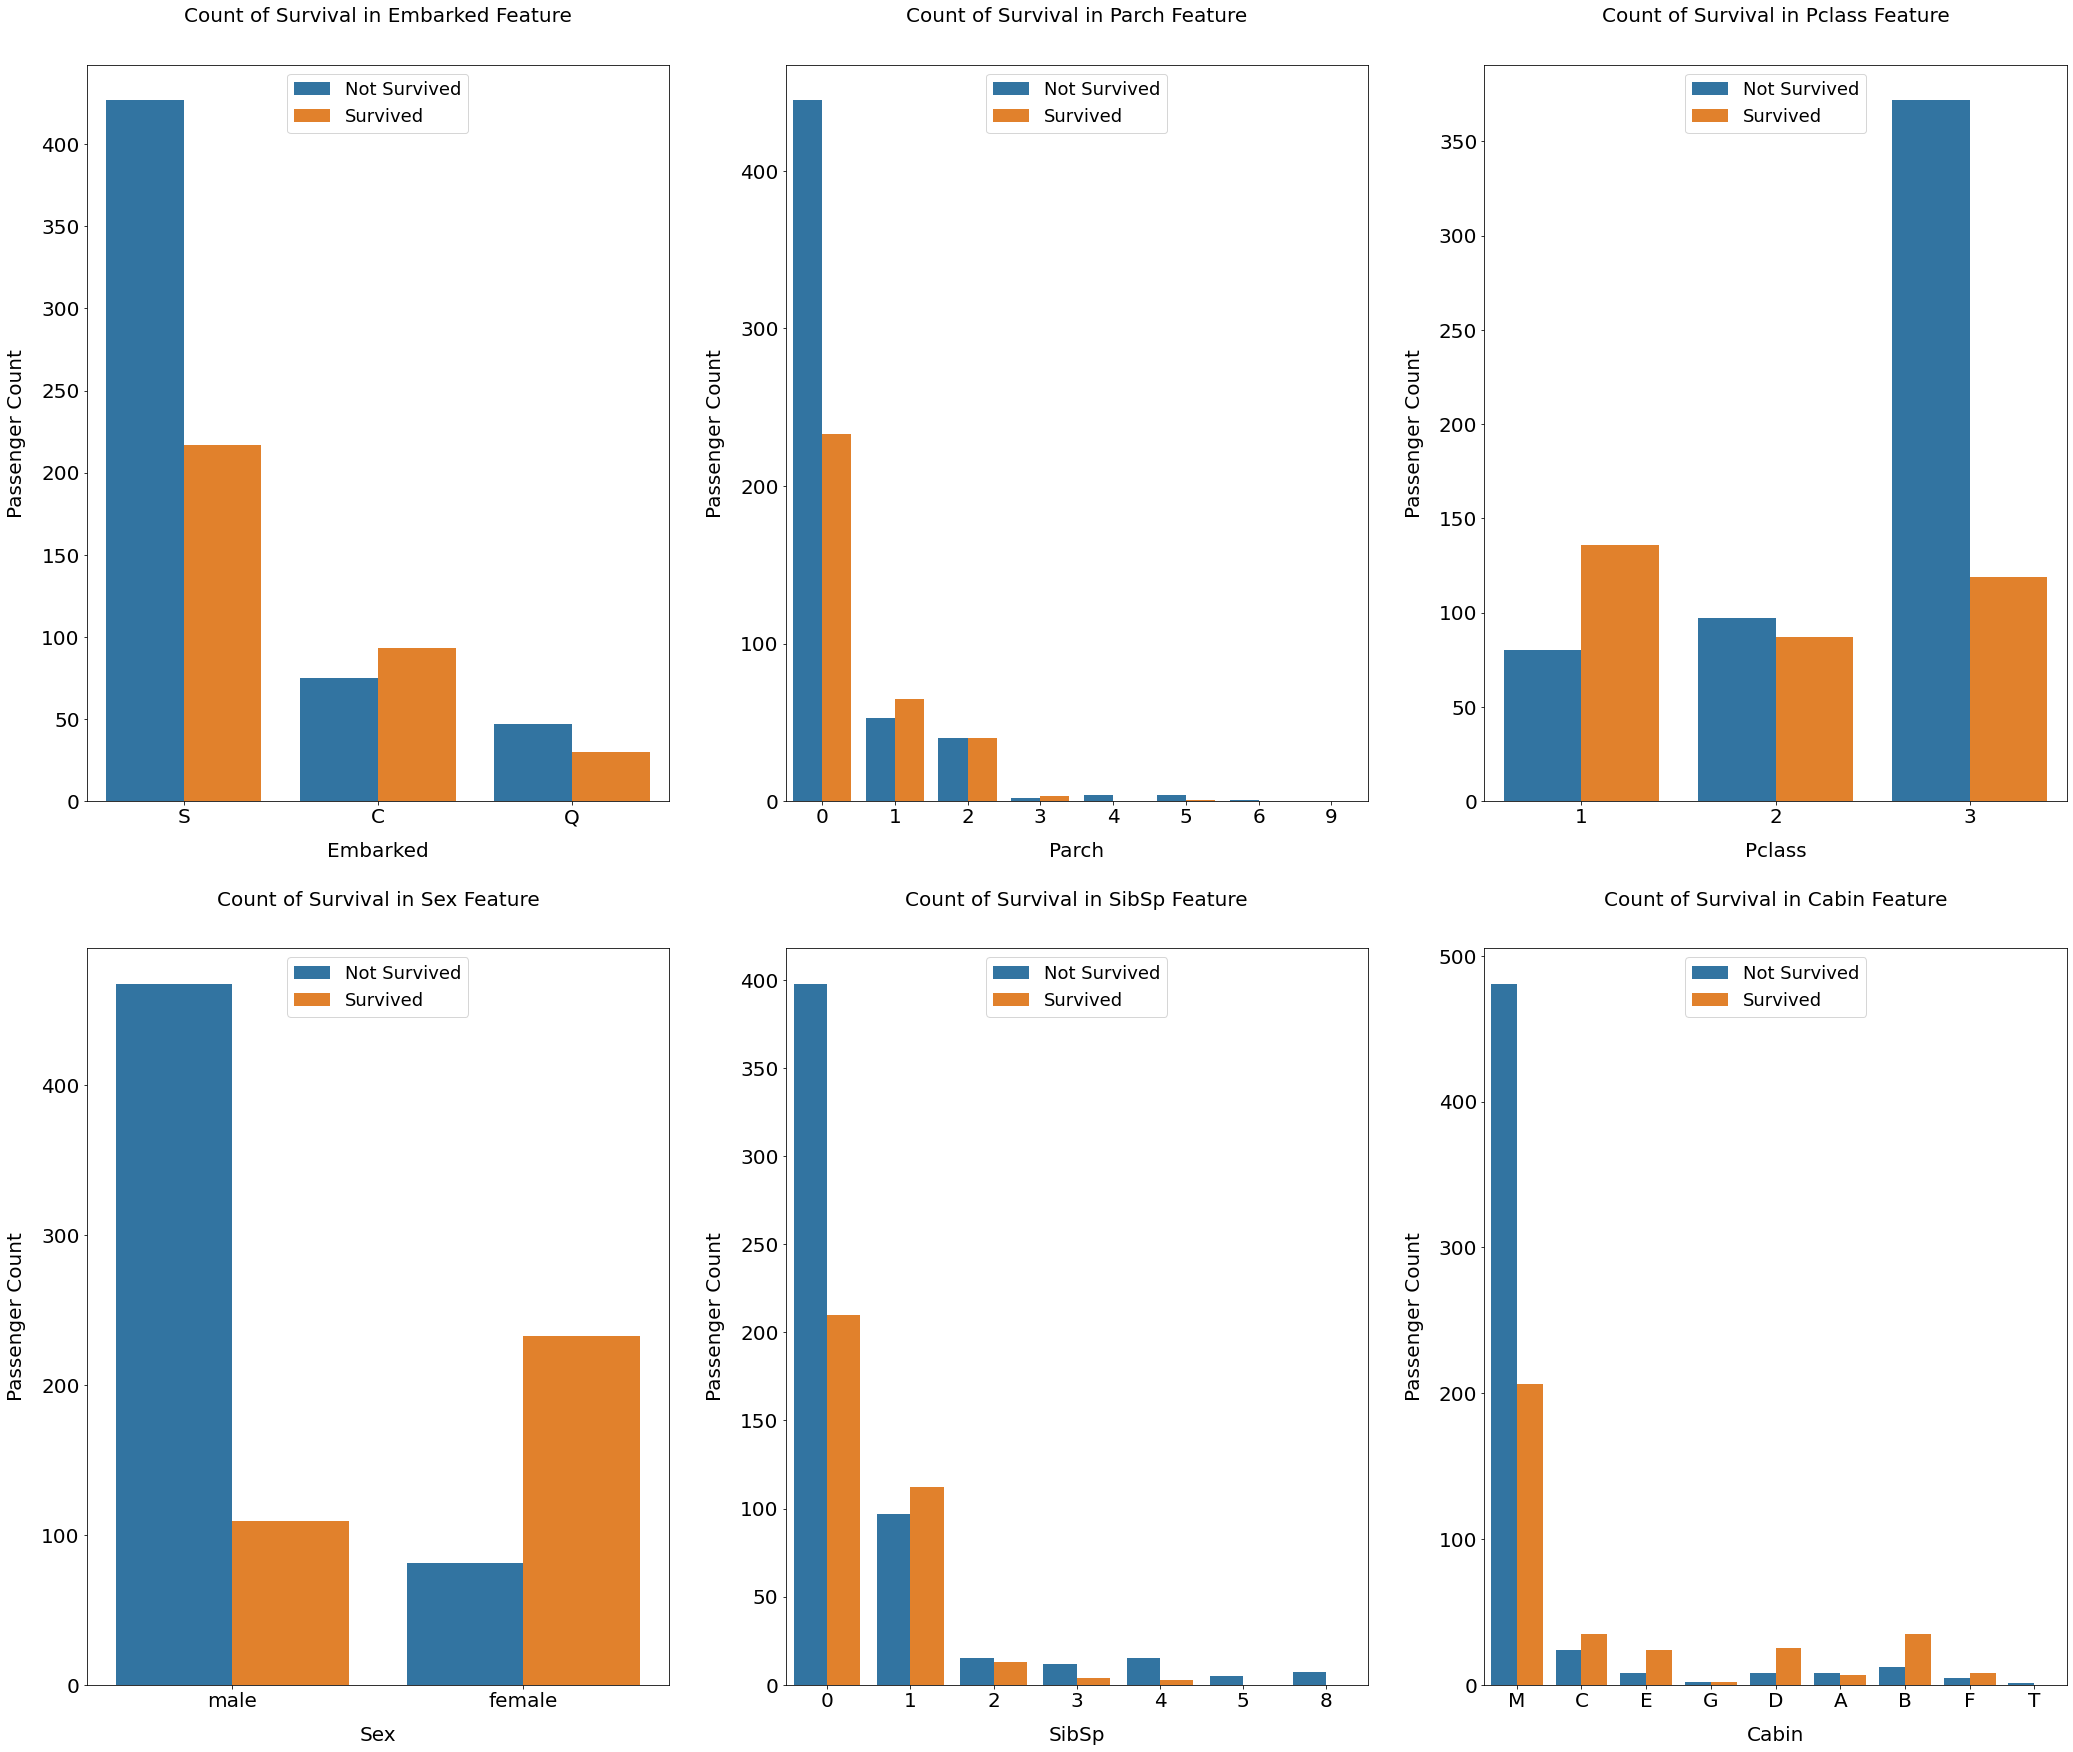

In [111]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Cabin']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_whole)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

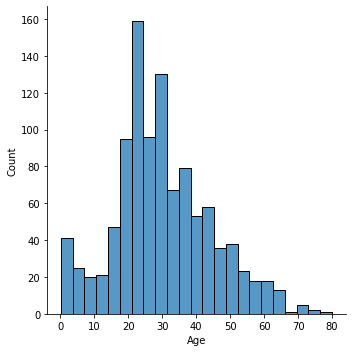

In [133]:
# Shapiro-Wilk test indicates, that 'Age' feature
# is from normal distr`ibution -> we will use z-standartization
# for this feature
sns.displot(df_whole, x='Age')

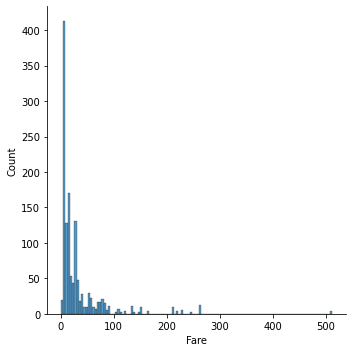

In [134]:
sns.displot(df_whole, x='Fare')

#**3. Feature generation conclusions**
1. We can regroup the SibSp & Parch feature on low, medium, high
2. Regroup Cabin column on BD, GFT, AE, C, M
3. Remove 'Ticket' and 'Name' Column
4. Standard-scale the 'age' column


In [113]:
# Replace Cabin feature
df_whole['Cabin'].replace(['B', 'D'], 'BD', inplace=True)
df_whole['Cabin'].replace(['F', 'G', 'T'], 'GFT', inplace=True)
df_whole['Cabin'].replace(['A', 'E'], 'AE', inplace=True)

In [118]:
# Replace Family feature
df_whole['SibSp'].replace([0, 1], 'HIGH', inplace=True)
df_whole['SibSp'].replace([2, 3, 4, 5, 6], 'LOW', inplace=True)

df_whole['Parch'].replace([0], 'HIGH', inplace=True)
df_whole['Parch'].replace([1, 2], 'MEDIUM', inplace=True)
df_whole['Parch'].replace([3, 4, 5, 6, 9], 'LOW', inplace=True)

In [125]:
# Drop Ticket and Name columnd
df_whole.drop(columns=['Ticket', 'Name'], inplace=True, axis=0)

# **4. Splitting whole dataset**

In [176]:
df_train = df_whole.loc[:890]
df_test = df_whole.loc[891:]

In [177]:
X = df_train.drop('Survived', axis=1)
Y = df_train['Survived']

In [180]:
X.columns
X['Embarked'] = X['Embarked'].fillna('S')
nan_statistics(X)
print(np.isnan(Y).any())

Column Age has 19.89 % of Nans
Age         177
Cabin         0
Embarked      0
Fare          0
Parch         0
Pclass        0
Sex           0
SibSp         0
dtype: int64
False


In [181]:
df_test['Fare'].fillna(df_test['Fare'].median(), inplace=True)
nan_statistics(df_test)
df_test.drop(columns = ['Survived'], inplace=True)
df_test.head()

Column Age has 20.53 % of Nans
Column Survived has 99.76 % of Nans
Age          86
Cabin         0
Embarked      0
Fare          0
Parch         0
Pclass        0
Sex           0
SibSp         0
Survived    418
dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp
PassengerId,,,,,,,,
891,32.0,M,Q,7.7500,HIGH,3,male,HIGH
892,34.5,M,Q,7.8292,HIGH,3,male,HIGH
893,47.0,M,S,7.0000,HIGH,3,female,HIGH
894,62.0,M,Q,9.6875,HIGH,2,male,HIGH
895,27.0,M,S,8.6625,HIGH,3,male,HIGH


In [203]:
column_transformer = make_column_transformer(
    (SimpleImputer(), ['Age']),
    (OneHotEncoder(), ['Sex', 'Parch', 'SibSp', 'Embarked', 'Cabin']),
    remainder='passthrough'
)

column_transformer_1 = make_column_transformer(
    (StandardScaler(), [0]), # Age
    (MinMaxScaler(), [3]), # Fare
    remainder='passthrough'
)

feature_remover = VarianceThreshold(threshold=0.02)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=3,
                                                    shuffle=True,
                                                    stratify=Y)

In [191]:
X_train.dtypes

Age         float64
Cabin        object
Embarked     object
Fare        float64
Parch        object
Pclass        int64
Sex          object
SibSp        object
dtype: object

In [204]:
model1 = LogisticRegression()
model2 = SVC()

pipeline = make_pipeline(
    column_transformer,
    #column_transformer_1,
    #feature_remover,
    model1
)

param_grid = {
    
}

result = GridSearchCV(pipeline, param_grid, cv=5)
result.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: argument must be a string or number

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: argument must be a string or number

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: argument must be a string or number

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

TypeError: ignored

In [ ]:
result.best_score_

0.8187629272136314

In [ ]:
best_model = result.best_estimator_
best_model.fit(X_train, Y_train)
pred = best_model.predict(test)

In [ ]:
# Saving the submission data to csv file
submission = pd.DataFrame({
    'PassengerId': test.index,
    'Survived': pred
})
submission.to_csv(gdrive_path + df_path + "submission.csv", index=False)